In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting


reload(misc)
reload(plotting)

first_year = 1990

data_dir = '.'
data_file = os.path.join(data_dir, 'guncontrol_with_metadata_2017.03.15.csv')

data = misc.read_tone_data(data_file, first_year)

last_date = data['date'].max()

print "Loaded data for %d articles" % len(data.index)

Loaded data for 9999 articles


### Group data and plot tone and directness

Grouped data into 76 periods


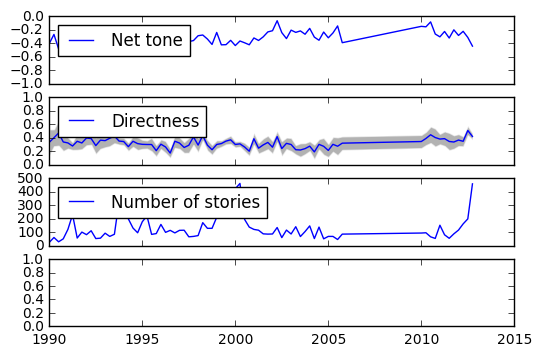

In [2]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_tone_data(data, group_by, use_frames=False)

print "Grouped data into %d periods" % len(grouped.index)

plotting.plot_variables(grouped, tone_min=-1, tone_max=0, plot_frames=False)

In [8]:
import datetime as dt

reload(misc)

filename = 'guncontrol_polls.csv'

polls = misc.load_polls(filename, first_year, last_date)
polls = polls[(polls['date'] < dt.date(2006,1,1)) | (polls['date'] > dt.date(2010,3,1))]


print "Loaded %d polls" % len(polls.index)
print polls.shape

Loaded 141 polls
(141, 28)


(0, 1)

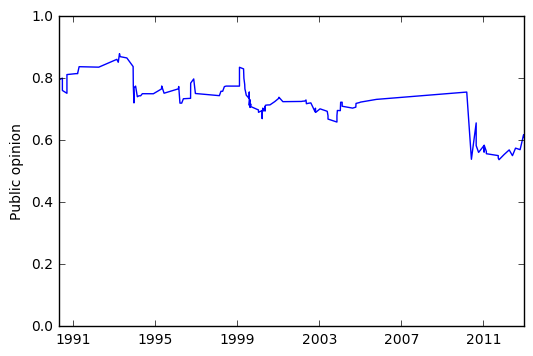

In [9]:
# calculate an exponentially-weighted running average for all polls and plot it

reload(misc)

running_average = misc.calculate_weighted_average(polls)
polls['running_average'] = running_average

plt.plot(polls['date'], polls['running_average']/100.0)
plt.ylabel('Public opinion')
plt.ylim(0, 1)

In [10]:
reload(misc)

combined = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30, use_frames=False)
#combined = misc.combine_polls_and_tone(polls, grouped)

print combined.describe()

              Pro     Neutral        Anti  directness     stories        tone  \
count  139.000000  139.000000  139.000000  139.000000  141.000000  139.000000   
mean     0.273696    0.123859    0.602444    0.325542   68.390071   -0.328748   
std      0.056333    0.021479    0.060423    0.104701   53.262527    0.114836   
min      0.191212    0.080565    0.454368    0.084672    0.000000   -0.520823   
25%           NaN         NaN         NaN         NaN   30.000000         NaN   
50%           NaN         NaN         NaN         NaN   47.000000         NaN   
75%           NaN         NaN         NaN         NaN  110.000000         NaN   
max      0.461653    0.173849    0.720129    0.803660  233.000000    0.007285   

            Value           N  running_average   GUNSTRICT     ...      \
count  141.000000  141.000000       140.000000  141.000000     ...       
mean     0.729421    0.281327         0.717913    0.078014     ...       
std      0.162653    0.177011         0.076571  

/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Question	Responses
  GUNLAW	39
  PEWGUN	23
FIREARMS	19
  GUNABC	16
GUNSTRICT	11
 BANGUNS	10
 HANDGUN	7
STRICTORC	5
 GALGUN2	4
HANDGUNS	2
HALLGUNS	2
HHANDGUN	1
 GUNLAWY	1
  GUNDIF	1



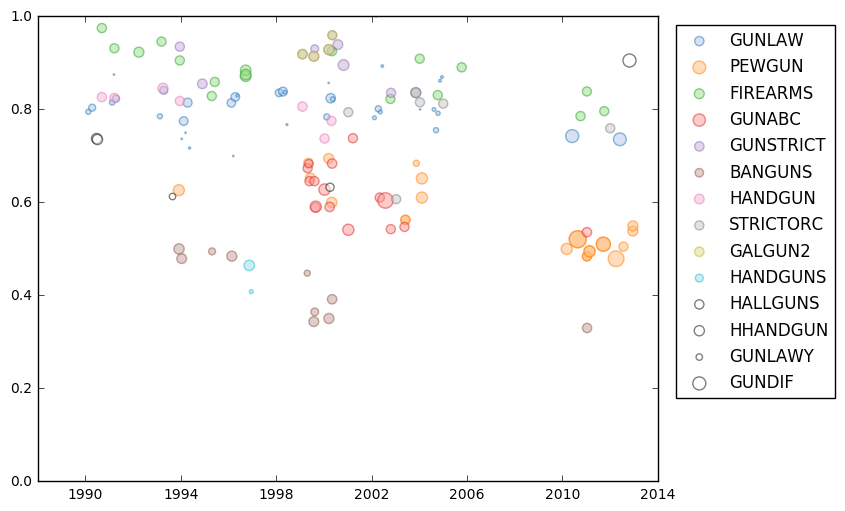

In [11]:
reload(plotting)

plotting.plot_polling_data(combined)
print ""

In [15]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 50), axis=1)

# add in interactions
# between tone and number of stories per quarter

#grouped['stories'] = np.log(grouped['stories'])


combined['toneXstories'] = combined['tone'] * combined['stories']
combined['directnessXstories'] = combined['directness'] * combined['stories']

combined['proXstories'] = combined['Pro'] * combined['stories']
combined['antiXstories'] = combined['Anti'] * combined['stories']
combined['neutralXstories'] = combined['Neutral'] * combined['stories']

#combined['entropyXstories'] = combined['entropy'] * combined['stories']
#combined['entropyXtone'] =  combined['entropy'] * combined['tone']
#combined['entropyXtoneXstories'] =  combined['entropy'] * combined['tone'] * combined['stories']

combined['toneXdirectness'] = combined['tone'] * combined['directness']
combined['toneXdirectnessXstories'] = combined['tone'] * combined['directness'] * combined['stories']

#combined['entropyXtoneXdirectness'] = combined['entropy'] * combined['tone'] * combined['directness']


combined['toneXsalient'] = combined['tone'] * combined['salient']
combined['directnessXsalient'] = combined['directness'] * combined['salient']

#for year in range(1990,2014):
#    combined['post_' + str(year)] = [int(combined.index[i][0] > year) for i in range(len(combined.index))]    
    
#combined['post_event_1990'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1991) for i in range(len(combined.index))]
#combined['post_event_1994'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1995) for i in range(len(combined.index))]
#combined['post_event_2000'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2000.5) for i in range(len(combined.index))]
#combined['post_event_2001'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2002) for i in range(len(combined.index))]
#combined['post_event_2006'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2006.5) for i in range(len(combined.index))]


In [17]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <GUNLAW> + <PEWGUN> + <FIREARMS> + <GUNABC> + <GUNSTRICT>
             + <BANGUNS> + <HANDGUN> + <STRICTORC> + <GALGUN2> + <intercept>

Number of Observations:         139
Number of Degrees of Freedom:   11

R-squared:         0.8616
Adj R-squared:     0.8508

Rmse:              0.0350

F-stat (10, 128):    79.7118, p-value:     0.0000

Degrees of Freedom: model 10, resid 128

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    -0.0194     0.0274      -0.71     0.4804    -0.0730     0.0343
        GUNLAW     0.0879     0.0145       6.07     0.0000     0.0596     0.1163
        PEWGUN    -0.1626     0.0153     -10.60     0.0000    -0.1927    -0.1326
      FIREARMS     0.1682    

In [18]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <GUNLAW> + <PEWGUN> + <FIREARMS>
             + <GUNABC> + <GUNSTRICT> + <BANGUNS> + <HANDGUN> + <STRICTORC>
             + <GALGUN2> + <intercept>

Number of Observations:         138
Number of Degrees of Freedom:   12

R-squared:         0.8764
Adj R-squared:     0.8656

Rmse:              0.0334

F-stat (11, 126):    81.1919, p-value:     0.0000

Degrees of Freedom: model 11, resid 126

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.2816     0.0424       6.64     0.0000     0.1985     0.3647
          tone     0.0033     0.0265       0.12     0.9011    -0.0487     0.0553
        GUNLAW     0.0935     0.0138       6.75     0.0000     0.0663     0.

In [16]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <GUNLAW> + <PEWGUN> + <FIREARMS> + <GUNABC>
             + <GUNSTRICT> + <BANGUNS> + <HANDGUN> + <STRICTORC> + <GALGUN2>
             + <intercept>

Number of Observations:         139
Number of Degrees of Freedom:   11

R-squared:         0.8640
Adj R-squared:     0.8533

Rmse:              0.0347

F-stat (10, 128):    81.2954, p-value:     0.0000

Degrees of Freedom: model 10, resid 128

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories    -0.0004     0.0001      -2.88     0.0047    -0.0006    -0.0001
        GUNLAW     0.0871     0.0143       6.11     0.0000     0.0592     0.1151
        PEWGUN    -0.1646     0.0151     -10.92     0.0000    -0.1942    -0.1351
      FI

In [19]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <toneXstories> + <GUNLAW> + <PEWGUN>
             + <FIREARMS> + <GUNABC> + <GUNSTRICT> + <BANGUNS> + <HANDGUN> + <STRICTORC>
             + <GALGUN2> + <intercept>

Number of Observations:         138
Number of Degrees of Freedom:   12

R-squared:         0.8781
Adj R-squared:     0.8674

Rmse:              0.0331

F-stat (11, 126):    82.4883, p-value:     0.0000

Degrees of Freedom: model 11, resid 126

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.2741     0.0418       6.56     0.0000     0.1922     0.3560
  toneXstories    -0.0003     0.0001      -2.50     0.0139    -0.0005    -0.0001
        GUNLAW     0.0926     0.0136       6.79     0.0000     0.065

In [20]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <GUNLAW> + <PEWGUN> + <FIREARMS> + <GUNABC>
             + <GUNSTRICT> + <BANGUNS> + <HANDGUN> + <STRICTORC> + <GALGUN2>
             + <intercept>

Number of Observations:         139
Number of Degrees of Freedom:   12

R-squared:         0.8636
Adj R-squared:     0.8518

Rmse:              0.0349

F-stat (11, 127):    73.1187, p-value:     0.0000

Degrees of Freedom: model 11, resid 127

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.0255     0.0316       0.81     0.4207    -0.0364     0.0873
       stories     0.0002     0.0001       2.72     0.0075     0.0001     0.0003
        GUNLAW     0.0861     0.0145       5.94     0.0000     0.0577     0.1146
    

In [21]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <GUNLAW> + <PEWGUN>
             + <FIREARMS> + <GUNABC> + <GUNSTRICT> + <BANGUNS> + <HANDGUN>
             + <STRICTORC> + <GALGUN2> + <intercept>

Number of Observations:         138
Number of Degrees of Freedom:   13

R-squared:         0.8785
Adj R-squared:     0.8668

Rmse:              0.0332

F-stat (12, 125):    75.3159, p-value:     0.0000

Degrees of Freedom: model 12, resid 125

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.2828     0.0426       6.64     0.0000     0.1994     0.3663
          tone     0.0505     0.0312       1.62     0.1081    -0.0107     0.1116
       stories     0.0002     0.0001       2.89     0.0045     0

In [22]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <GUNLAW> + <PEWGUN>
             + <FIREARMS> + <GUNABC> + <GUNSTRICT> + <BANGUNS> + <HANDGUN> + <STRICTORC>
             + <GALGUN2> + <intercept>

Number of Observations:         139
Number of Degrees of Freedom:   13

R-squared:         0.8662
Adj R-squared:     0.8535

Rmse:              0.0347

F-stat (12, 126):    67.9968, p-value:     0.0000

Degrees of Freedom: model 12, resid 126

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.1000     0.0453       2.21     0.0291     0.0112     0.1889
       stories    -0.0007     0.0003      -2.26     0.0256    -0.0013    -0.0001
  toneXstories    -0.0022     0.0008      -2.86     0.0049    -0.003

In [23]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <GUNLAW>
             + <PEWGUN> + <FIREARMS> + <GUNABC> + <GUNSTRICT> + <BANGUNS>
             + <HANDGUN> + <STRICTORC> + <GALGUN2> + <intercept>

Number of Observations:         138
Number of Degrees of Freedom:   14

R-squared:         0.8814
Adj R-squared:     0.8690

Rmse:              0.0329

F-stat (13, 124):    70.9091, p-value:     0.0000

Degrees of Freedom: model 13, resid 124

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.2860     0.0423       6.76     0.0000     0.2031     0.3689
          tone     0.1300     0.0443       2.93     0.0040     0.0431     0.2169
       stories    -0.0008     0.0003      -2.54